# Structure from Motion

Epipolar line coefficients: [ 0.00515033 -0.02782258  1.32032848]


Text(0.5, 1.0, 'Epipolar Line')

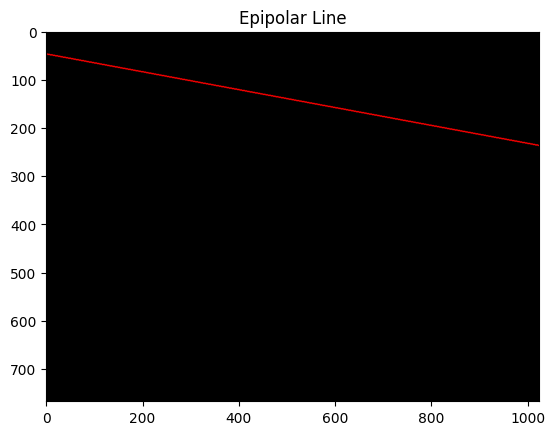

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Initiate ORB detector
orb = cv2.ORB_create()

images = [os.path.join('beethoven/images/', path) for path in sorted(os.listdir('beethoven/images/'))]
silhouettes = [os.path.join('beethoven/silhouettes/', path) for path in sorted(os.listdir('beethoven/silhouettes/'))]

def get_masked_img(index):
    img = cv2.imread(images[index])
    silhouette = cv2.imread(silhouettes[index], cv2.IMREAD_GRAYSCALE)
    
    inv_silhouette = cv2.bitwise_not(silhouette)
    
    masked_img = cv2.bitwise_and(img, img, mask=inv_silhouette)
    
    return masked_img

def extract_features(image, orb):
    # find the keypoints with ORB
    kp = orb.detect(image,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(image, kp)
    return kp, des

def match_features(des1, des2):
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des1, des2)
    # Sort them in ascending order of distance
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def get_matched_keypoints(kp1, kp2, matches):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    return pts1, pts2

def estimate_fundamental_matrix(pts1, pts2):
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    # We select only inlier points
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    return F, pts1, pts2

def compute_projection_matrices(F):
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    print(P1)
    U, S, Vt = np.linalg.svd(F.T)
    print(Vt)
    e = Vt[-1] / Vt[-1][2]

    def skew(x):
        return np.array([[0, -x[2], x[1]],
                         [x[2], 0, -x[0]],
                         [-x[1], x[0], 0]])

    ex = skew(e)
    P2 = np.hstack((ex @ F, e.reshape(3, 1)))
    return P1, P2

def triangulate_points(P1, P2, pts1, pts2):
    pts1_h = pts1.T
    pts2_h = pts2.T
    pts4d = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
    pts3d = (pts4d[:3] / pts4d[3]).T
    return pts3d

img1 = get_masked_img(2)
img2 = get_masked_img(3)
kp1, des1 = extract_features(img1, orb)
kp2, des2 = extract_features(img2, orb)
matches = match_features(des1, des2)
pts1, pts2 = get_matched_keypoints(kp1, kp2, matches)
F, pts1, pts2 = estimate_fundamental_matrix(pts1, pts2)

# calculate the epipolar line for one point pair using the fundamental matrix and numpy

line = F @ np.array([pts1[0][0], pts1[0][1], 1])
print("Epipolar line coefficients:", line)
# draw the line in a blank image
h, w = img1.shape[:2]
x0, y0 = 0, int(-line[2] / line[1])  # y-intercept
x1, y1 = w, int(-(line[2] + line[0] * w) / line[1])  # x-intercept
epipolar_line_img = np.zeros((h, w, 3), dtype=np.uint8)
cv2.line(epipolar_line_img, (x0, y0), (x1, y1), (255, 0, 0), 2)
plt.imshow(epipolar_line_img)
plt.title('Epipolar Line')

# P1, P2 = compute_projection_matrices(F)
# pts3d = triangulate_points(P1, P2, pts1, pts2)

# # Visualize triangulated points
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], c='r', marker='o')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()

# kp, des = extract_features(img, orb)
# # draw only keypoints location,not size and orientation
# img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
# plt.imshow(img2), plt.show()
# # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [39]:
import cv2
import numpy as np

P = np.array([
    [-359.461, 1279.16, -368.388, 30037.9],
    [ 630.761, -1.54358, -1179.57, 17557.1],
    [-0.703259, 0.00502606, -0.710916, 57.7507]
])

K, R, t, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
t = t[:3] / t[3]

print("K:", K)
print("R:", R)
print("t:", t)

K: [[1.27656183e+03 7.53876948e-04 5.21116231e+02]
 [0.00000000e+00 1.27798229e+03 3.94979070e+02]
 [0.00000000e+00 0.00000000e+00 1.00000002e+00]]
R: [[ 0.00549769  0.99998356  0.00163125]
 [ 0.71091249 -0.0027612  -0.70327505]
 [-0.70325899  0.00502606 -0.71091599]]
t: [[43.53618834]
 [-0.25701811]
 [38.16511646]]
